# Data Preparation

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

data_path = 'data.csv'
data = pd.read_csv(data_path)

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data_cleaned = data.dropna()
data_cleaned.index.freq = 'D'

# Augmented Dickey-Fuller test to test for stationarity
adf_result = adfuller(data_cleaned['ggr'])

adf_result



(-4.088043892579941,
 0.001013548202709621,
 14,
 1298,
 {'1%': -3.4353979810093374,
  '5%': -2.863769264797245,
  '10%': -2.5679568752685773},
 33756.42428476671)

ADF statistic < the critical values at the $1\%$, $5\%$, and $10\%$ levels and the p-value is significantly low, so we can reject the null hypothesis. This implies that the GGR series is stationary.

In [158]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX


exog_variables = data_cleaned.drop(columns=['ggr'])

train_data, test_data = train_test_split(data_cleaned, test_size=0.2, shuffle=False)


# Selection of the best parameters

In [154]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(train_data['ggr'],
                              exogenous=train_data[exog_variables.columns],
                              start_p=0, start_q=0,
                              max_p=4, max_q=4, m=4,
                              start_P=0, seasonal=True,
                              start_Q=0, max_P=3, max_Q=3,
                              d=None, D=None, trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

auto_arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=27830.111, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=27695.704, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=27566.524, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=27828.115, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=27574.017, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=27568.523, Time=0.14 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=27568.523, Time=0.62 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=27566.610, Time=0.07 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=27570.525, Time=0.58 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=27830.735, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=27526.374, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=27524.667, Time=0.11 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=27526.294, Time=0.10 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[4] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1050
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -13753.754
Date:                Fri, 26 Apr 2024   AIC                          27517.509
Time:                        19:23:42   BIC                          27542.287
Sample:                    05-28-2020   HQIC                         27526.904
                         - 04-12-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9010      0.037     24.173      0.000       0.828       0.974
ma.L1         -1.4818      0.041    -36.108      0.000      -1.562      -1.401
ma.L2          0.3364      0.034      9.902      0.000       0.270       0.403
ma.L3          0.1507      0.028      5.338      0.000       0.095       0.206
sigma2      1.463e+10   8.49e-13   1.72e+22      0.000    1.46e+10    1.46e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             15037.74
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.62   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.63e+37. Standard errors may be unstable.
"""

# Expanding window analysis

In [155]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error
import numpy as np

initial_train_size = int(len(data_cleaned) * 0.8)
train_data, test_data = train_test_split(data_cleaned, test_size=0.2, shuffle=False)

mape_scores = []
rmse_scores = []

# Expanding window analysis
for end in range(initial_train_size, len(data_cleaned)):
    train = data_cleaned.iloc[:end] 
    actual = data_cleaned.iloc[end] 

    model = SARIMAX(train['ggr'], exog=train[exog_variables.columns], order=(1, 1, 3), seasonal_order=(0, 0, 0, 4),
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False, maxiter=500)
    
    forecast = results.get_forecast(steps=1, exog=actual[exog_variables.columns]).predicted_mean.iloc[-1]  
    
    mape_score = np.abs((forecast - actual['ggr']) / actual['ggr']) * 100 if actual['ggr'] != 0 else 0  
    rmse_score = root_mean_squared_error([actual['ggr']], [forecast])
    
    mape_scores.append(mape_score)
    rmse_scores.append(rmse_score)

mean_mape = np.mean(mape_scores)
mean_nrmse = np.mean(rmse_scores / (data['ggr'].max() - data['ggr'].min()))

print(f"Mean MAPE across expanding window: {mean_mape:.2f}%")
print(f"Mean NRMSE across expanding window: {mean_nrmse:.2f}")


Mean MAPE across expanding window: 4.84%
Mean NRMSE across expanding window: 0.02


# Test

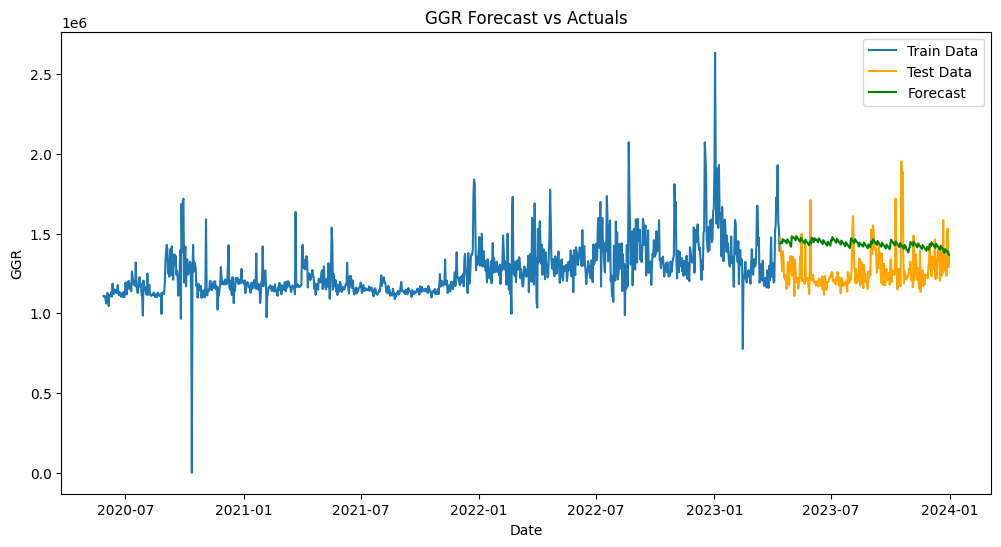

MAPE on Test Data: 15.31%
NRMSE on Test Data: 0.08


In [159]:
import matplotlib.pyplot as plt

model_full = SARIMAX(train_data['ggr'],
                     exog=train_data[exog_variables.columns],
                     order=(1, 1, 3),
                     seasonal_order=(0, 0, 0, 4),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
results_full = model_full.fit(disp=False)

import pickle

# Save the model to disk
with open('sarimax_model.pkl', 'wb') as pkl:
    pickle.dump(results_full, pkl)

# Test the model 
forecast_full = results_full.get_forecast(steps=len(test_data), exog=test_data[exog_variables.columns])
forecast_mean_full = forecast_full.predicted_mean

# MAPE and NRMSE for the test data
test_actuals = test_data['ggr']
test_forecast = forecast_mean_full
mape_test = np.mean(np.abs((test_actuals - test_forecast) / test_actuals)) * 100
nrmse_test = root_mean_squared_error(test_actuals, test_forecast) / (data['ggr'].max() - data['ggr'].min())


plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['ggr'], label='Train Data')
plt.plot(test_data.index, test_data['ggr'], label='Test Data', color='orange')
plt.plot(test_data.index, forecast_mean_full, label='Forecast', color='green')
plt.title('GGR Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('GGR')
plt.legend()
plt.show()

print(f"MAPE on Test Data: {mape_test:.2f}%")
print(f"NRMSE on Test Data: {nrmse_test:.2f}")
